In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

In [2]:
from keras.layers import Conv2D,Dense,Activation,MaxPooling2D,Flatten,BatchNormalization,Dropout,InputLayer
from keras.models import Sequential

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
class cnn_model:
    def __init__(self,input_shape):
        self.input_shape = input_shape
        self.model = Sequential()
        self.model.add(InputLayer(input_shape=input_shape))
        
    def add_cnn_block(self,nfilters=16,filter_size=(2,2),activation='relu',pool_size=(2,2),batch_norm='yes',dropout=None):
        self.model.add(Conv2D(nfilters,filter_size,padding="same"))
        if batch_norm == 'yes':
            self.model.add(BatchNormalization())
        self.model.add(Activation(activation))
        if dropout is not None:
            self.model.add(Dropout(dropout))
        self.model.add(MaxPooling2D(pool_size=pool_size))
        
    def add_dense_layer(self,neurons=16):
        self.model.add(Flatten())
        self.model.add(Dense(neurons,activation='relu'))
        
    def build_model(self,output,loss='categorical_crossentropy',lr=1e-4):
        self.model.add(Dense(output,activation='softmax'))
        optz = keras.optimizers.Adam(lr)
        self.model.compile(optimizer=optz,loss=loss,metrics=['accuracy'])
#         self.model.summary()
        return self.model

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

pref = '../inaturalist_12K/'
 
train_generator = train_datagen.flow_from_directory(
    pref+'train',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical')

val_generator = test_datagen.flow_from_directory(
    pref+'val',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical')

Found 8999 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [7]:
classes = list(train_generator.class_indices.keys())
classes

['Amphibia',
 'Animalia',
 'Arachnida',
 'Aves',
 'Fungi',
 'Insecta',
 'Mammalia',
 'Mollusca',
 'Plantae',
 'Reptilia']

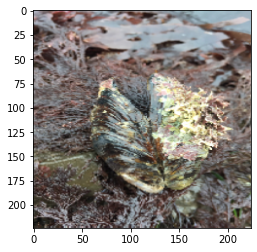

Mollusca


In [8]:
x,y = train_generator.next()

img = x[0]
plt.imshow(img)
plt.show()
print(classes[np.argmax(y[0])])

In [9]:
def make_model(filters,filter_size,batch_norm,dropout,dense_size,lr):
    keras.backend.clear_session()
    model = cnn_model((224,224,3))
    for i in range(5):
        model.add_cnn_block(nfilters=filters[i],filter_size=filter_size[i],batch_norm=batch_norm,dropout=dropout)
    model.add_dense_layer(dense_size)
    training = model.build_model(10,lr=lr)
    return training

In [10]:
flts = [32,64,128,256,512]
fltsz = [(11,11),(7,7),(5,5),(3,3),(2,2)]
best = make_model(flts,fltsz,"yes",0,128,1e-5)

In [15]:
best.fit(train_generator,
        steps_per_epoch=100,
        epochs=20,
        validation_data=val_generator,
        validation_steps=25)

Epoch 1/20
100/100 [==============================] - 32s 320ms/step - loss: 1.5655 - accuracy: 0.4481 - val_loss: 1.7899 - val_accuracy: 0.3878
Epoch 2/20
100/100 [==============================] - 35s 355ms/step - loss: 1.5609 - accuracy: 0.4575 - val_loss: 1.8920 - val_accuracy: 0.3375
Epoch 3/20
100/100 [==============================] - 36s 361ms/step - loss: 1.5534 - accuracy: 0.4588 - val_loss: 1.9393 - val_accuracy: 0.3250
Epoch 4/20
100/100 [==============================] - 37s 373ms/step - loss: 1.5265 - accuracy: 0.4663 - val_loss: 1.9427 - val_accuracy: 0.3189
Epoch 5/20
100/100 [==============================] - 39s 393ms/step - loss: 1.5636 - accuracy: 0.4544 - val_loss: 1.7904 - val_accuracy: 0.3875
Epoch 6/20
100/100 [==============================] - 43s 431ms/step - loss: 1.4847 - accuracy: 0.4881 - val_loss: 2.0099 - val_accuracy: 0.3214
Epoch 7/20
100/100 [==============================] - 44s 438ms/step - loss: 1.5387 - accuracy: 0.4576 - val_loss: 1.8198 - val_ac

In [16]:
best.save('best_model.h5')

## WandB Sweep

In [10]:
import wandb
from wandb.keras import WandbCallback

In [11]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [7]
        },
        'lr': {
            'values': [1e-5,1e-6]
        },
        'filters': {
            'values': [[32,64,128,256,512],
                       [64,64,64,64,64],
                       [512,256,128,64,32]
                      ]
        },
        'filter_size': {
            'values': [[(11,11),(7,7),(5,5),(3,3),(2,2)],
                       [(2,2),(3,3),(5,5),(5,5),(7,7)],
                       [(3,3),(3,3),(3,3),(3,3),(3,3)]
                      ]
        },
        'dense_size': {
            'values': [128,512,1024]
        },
        'batch_norm': {
            'values': ["yes","no"]
        },
        'dropout': {
            'values': [0.0,0.2,0.5]
        }
    }
}


In [12]:
sweep_id = wandb.sweep(sweep_config,entity = "notarchana" , project = "cs6910-A1")

Create sweep with ID: ggmlx84v
Sweep URL: https://wandb.ai/notarchana/CS6910-A1/sweeps/ggmlx84v


In [13]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 7,
        'lr': 1e-5,
        'filters': [32,64,128,256,512],
        'filter_size': [(11,11),(7,7),(5,5),(3,3),(2,2)],
        'dense_size': 1024,
        'batch_norm': "yes",
        'dropout': None
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults,name="cs6910-a2")
    
    cfg = wandb.config
    
    name = f'flt_{cfg.filters}_fltsz_{cfg.filter_size}_bn_{cfg.batch_norm}_lr_{cfg.lr}_do_{cfg.dropout}_dsz_{cfg.dense_size}'
    wandb.run.name = name
    wandb.run.save()
    
    # Config is a variable that holds and saves hyperparameters and inputs
    
    model = make_model(cfg.filters,cfg.filter_size,cfg.batch_norm,cfg.dropout,cfg.dense_size,cfg.lr)
    print("model building done")
    trained = model.fit(train_generator,
                steps_per_epoch=1000,
                epochs=cfg.epochs,
                validation_data=val_generator,
                validation_steps=100,
                use_multiprocessing=True,
                workers = 4,
                callbacks=[WandbCallback(monitor='val_accuracy',mode='max')]
    )

    print("model training done")


In [14]:
np.random.seed(42)
wandb.agent(sweep_id, train,count=20)

wandb: Agent Starting Run: i3hb6vz8 with config:
wandb: 	batch_norm: no
wandb: 	dense_size: 512
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	filter_size: [[11, 11], [7, 7], [5, 5], [3, 3], [2, 2]]
wandb: 	filters: [512, 256, 128, 64, 32]
wandb: 	lr: 1e-06
wandb: Currently logged in as: notarchana (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 1/7


Run i3hb6vz8 errored: ResourceExhaustedError()
wandb: ERROR Run i3hb6vz8 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 0fzlgxr7 with config:
wandb: 	batch_norm: yes
wandb: 	dense_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	filter_size: [[11, 11], [7, 7], [5, 5], [3, 3], [2, 2]]
wandb: 	filters: [512, 256, 128, 64, 32]
wandb: 	lr: 1e-06
wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


model building done
Epoch 1/7


wandb: Ctrl + C detected. Stopping sweep.
